In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
file_path = '/content/synthetic_heart_attack_data_balanced.csv'
dataset = pd.read_csv(file_path)

In [3]:
label_encoder_status = LabelEncoder()
label_encoder_risk = LabelEncoder()

In [4]:
dataset['Device Status'] = label_encoder_status.fit_transform(dataset['Device Status'])
dataset['Heart Attack Risk'] = label_encoder_risk.fit_transform(dataset['Heart Attack Risk'])

In [ ]:
X = dataset.drop(columns=['Heart Attack Risk','Accelerometer_X (m/s²)','Accelerometer_Y (m/s²)','Accelerometer_Z (m/s²)','Gyroscope_X (°/s)','Gyroscope_Y (°/s)','Gyroscope_Z (°/s)'])
y = dataset['Heart Attack Risk']

In [6]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [8]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [9]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 neurons for 'Yes', 'No', 'NA'
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8313 - loss: 0.4360 - val_accuracy: 0.9279 - val_loss: 0.2066
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9235 - loss: 0.2224 - val_accuracy: 0.9308 - val_loss: 0.2029
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9305 - loss: 0.2048 - val_accuracy: 0.9361 - val_loss: 0.1847
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9326 - loss: 0.1943 - val_accuracy: 0.9371 - val_loss: 0.1803
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9341 - loss: 0.1916 - val_accuracy: 0.9387 - val_loss: 0.1767
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9374 - loss: 0.1817 - val_accuracy: 0.9407 - val_loss: 0.1843
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9362 - loss: 0.1857 - val_accuracy: 0.9404 - val_loss: 0.1720
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9383 - loss: 0.1797 -

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9445 - loss: 0.1525
Test Loss: 0.1507, Test Accuracy: 0.9465


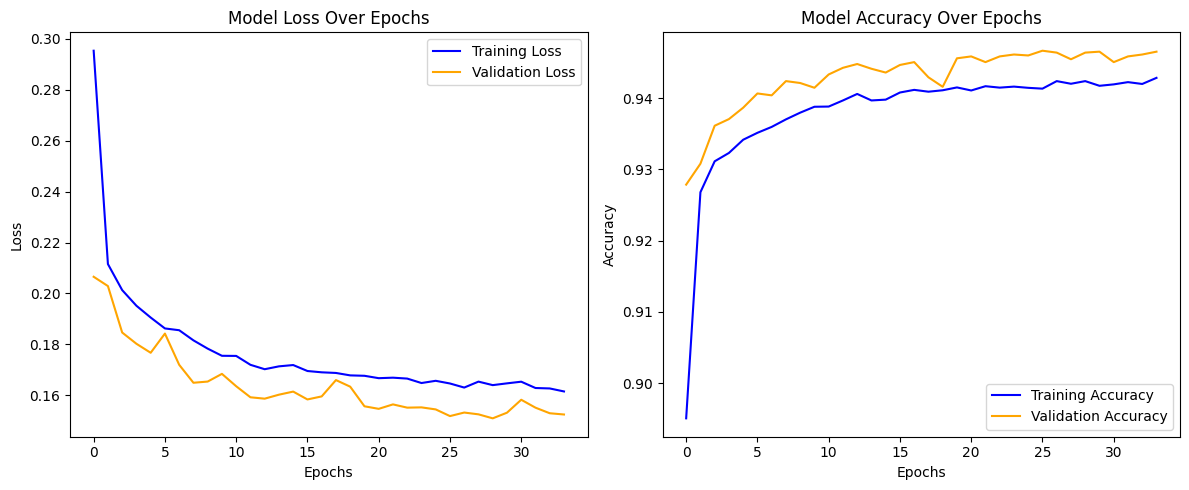

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = [str(cls) for cls in label_encoder_risk.classes_]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

          No       0.85      1.00      0.92      2100
         Yes       0.99      1.00      1.00      2475
         nan       1.00      0.87      0.93      2925

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500

